In [34]:
import polars as pl
import scipy.sparse as sps
from scipy import sparse
import numpy as np 
from matplotlib import pyplot as plt

In [149]:
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_demo/articles.parquet')

behaviors_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_demo/train/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_demo/train/history.parquet')

In [150]:
dataset = behaviors_train.explode('article_ids_inview').rename({'article_ids_inview': 'article'})

In [151]:
topics = articles.select('topics').explode('topics').unique('topics').to_numpy()
topics = [topic[0] for topic in topics]
topics = [topic for topic in topics if topic is not None]

In [164]:
period ='10h'

end_2 = dataset.select('article', 'impression_time')\
        .join(articles.select(['article_id','topics']), left_on = 'article', right_on = 'article_id')\
        .explode('topics')\
     .with_columns(pl.col('impression_time').dt.round('1m').alias('impression_time_rounded'))\
     .group_by(['impression_time_rounded','topics']).len()\
        .rename({'impression_time_rounded': 'impression_time', 'len':f'topic_endorsement_{period}'}) \
        .sort("impression_time").set_sorted("impression_time") \
        .rolling(index_column="impression_time", period=period, group_by='topics').agg(
            pl.col(f'topic_endorsement_{period}').sum()
        ).unique(subset = ['topics','impression_time'])

aggregate_col = end_2.columns
drop_cols = ['article', 'impression_time', 'impression_id','topics']
aggregate_col = [c for c in aggregate_col if c not in drop_cols]

to_join = dataset.select('article', 'impression_time')\
        .join(articles.select(['article_id','topics']), left_on = 'article', right_on = 'article_id')\
        .explode('topics')\
        .join_asof(end_2, by='topics', on='impression_time')\
        .unique(subset = ['article','topics','impression_time'])\
        .pivot(index=['article','impression_time'], columns="topics", values="topic_endorsement_10h").fill_null(0).fill_nan(0)
        # .agg(
        #       *[pl.col(column).mean().alias(f'mean_{column}') for column in aggregate_col],
        #       *[pl.col(column).max().alias(f'max_{column}') for column in aggregate_col],
        #       *[pl.col(column).min().alias(f'min_{column}') for column in aggregate_col],
        # )

dataset = dataset.join(to_join, on = ['article','impression_time'])

In [165]:
dataset

impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage,mean_topic_endorsement_10h,max_topic_endorsement_10h,min_topic_endorsement_10h,topics,topic_endorsement_10h,Livsstil,International politik,Begivenhed,Kendt,Kriminalitet,Mikro,Personfarlig kriminalitet,Erhverv,Sport,Partnerskab,Ansættelsesforhold,Økonomi,Politik,Større transportmiddel,Ungdomsuddannelse,…,Sygdom og behandling,Videnskab,Renovering og indretning,Bandekriminalitet,Vejr,Bil,Kunst,Teknologi,Naturvidenskab,Byliv,Bolig,Mad og drikke,Håndbold,Bedrageri,Motorsport,Dyr,Terror,Uddannelse,Makro,Køb og salg,Kunstig intelligens og software,Litteratur,Mindre transportmiddel,Offentlig instans,Forbrugerelektronik,Kosmetisk behandling,Samfundsvidenskab og humaniora,Bæredygtighed og klima,Mærkedag,Tendenser,null,Videregående uddannelse,Offentlig transport,Religion,Fritid,Udlejning,Museum og seværdighed
u32,i32,datetime[μs],f32,f32,i8,i32,list[i32],u32,bool,i8,i8,i8,bool,u32,f32,f32,f64,u32,u32,str,u32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
48401,null,2023-05-21 21:06:50,21.0,null,2,9774516,[9759966],22779,false,null,null,null,false,21,16.0,27.0,4162.5,7857,327,"""Kendt""",7857,0,0,0,26215,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48401,null,2023-05-21 21:06:50,21.0,null,2,9774516,[9759966],22779,false,null,null,null,false,21,16.0,27.0,4162.5,7857,327,"""Livsstil""",3184,0,0,0,26215,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48401,null,2023-05-21 21:06:50,21.0,null,2,9774516,[9759966],22779,false,null,null,null,false,21,16.0,27.0,4162.5,7857,327,"""Begivenhed""",5282,0,0,0,26215,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48401,null,2023-05-21 21:06:50,21.0,null,2,9774516,[9759966],22779,false,null,null,null,false,21,16.0,27.0,4162.5,7857,327,"""Personlig begivenhed""",327,0,0,0,26215,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48401,null,2023-05-21 21:06:50,21.0,null,2,9771051,[9759966],22779,false,null,null,null,false,21,16.0,27.0,553.75,1303,187,"""Økonomi""",1303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,370,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
580097289,9770541,2023-05-18 10:56:49,107.0,100.0,1,9726171,[9770369],2096611,false,null,null,null,false,73638,73.0,7.0,1582.833333,4555,26,"""Underholdning""",2652,0,0,0,32505,0,3073,0,0,0,0,0,3925,0,0,0,…,0,0,0,0,0,0,0,0,0,0,1929,0,0,0,0,0,0,0,0,888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
580097289,9770541,2023-05-18 10:56:49,107.0,100.0,1,9726171,[9770369],2096611,false,null,null,null,false,73638,73.0,7.0,1582.833333,4555,26,"""Økonomi""",1523,0,0,0,32505,0,3073,0,0,0,0,0,3925,0,0,0,…,0,0,0,0,0,0,0,0,0,0,1929,0,0,0,0,0,0,0,0,888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
580097289,9770541,2023-05-18 10:56:49,107.0,100.0,1,9726171,[9770369],2096611,false,null,null,null,false,73638,73.0,7.0,1582.833333,4555,26,"""Mikro""",693,0,0,0,32505,0,3073,0,0,0,0,0,3925,0,0,0,…,0,0,0,0,0,0,0,0,0,0,1929,0,0,0,0,0,0,0,0,888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [132]:
tmp = dataset.select('article', 'impression_time')\
        .join(articles.select(['article_id','topics']), left_on = 'article', right_on = 'article_id')\
        .explode('topics')\
        .join_asof(end_2, by='topics', on='impression_time')\
        .unique(subset = ['article', 'impression_time', 'topics'])\
        

In [133]:
tmp

article,impression_time,topics,topic_endorsement_10h
i32,datetime[μs],str,u32
9767697,2023-05-18 15:17:40,"""Politik""",2133
9746360,2023-05-18 11:57:16,"""Underholdning""",2611
9778226,2023-05-24 07:28:31,"""Kendt""",4701
9778413,2023-05-24 04:02:02,"""Personfarlig kriminalitet""",2708
9775793,2023-05-22 10:06:58,"""Økonomi""",1336
…,…,…,…
9777320,2023-05-23 13:11:55,"""Økonomi""",1484
9774376,2023-05-21 08:38:16,"""Erhverv""",1877
9772115,2023-05-19 12:20:22,"""Sygdom og behandling""",361


In [134]:
tmp = tmp.pivot(index=['article','impression_time'], columns="topics", values="topic_endorsement_10h").fill_null(0)

In [135]:
tmp

article,impression_time,Politik,Underholdning,Kendt,Personfarlig kriminalitet,Økonomi,Sundhed,Underholdningsbegivenhed,Kriminalitet,Sport,Fodbold,Sportsbegivenhed,Livsstil,Musik og lyd,Privat virksomhed,Mindre ulykke,Personlig begivenhed,Partnerskab,Konflikt og krig,Erotik,Offentlig transport,International politik,Begivenhed,Katastrofe,Mad og drikke,Krop og velvære,Transportmiddel,Kunstig intelligens og software,Familieliv,Cykling,Teknologi,Film og tv,Sygdom og behandling,Mikro,Større transportmiddel,Vejr,…,Naturvidenskab,Bandekriminalitet,Samfund,Bil,Ketcher- og batsport,Kultur,Samfundsvidenskab og humaniora,Rejse,Byliv,Videnskab,Bæredygtighed og klima,Bolig,Værdier,Uddannelse,null,Kosmetisk behandling,Større katastrofe,Ansættelsesforhold,Renovering og indretning,Offentlig instans,Håndbold,Mindre transportmiddel,Bedrageri,Grundskole,Kunst,Motorsport,Ungdomsuddannelse,Forbrugerelektronik,Mærkedag,Videregående uddannelse,Litteratur,Tendenser,Udlejning,Religion,Fritid,Terror,Museum og seværdighed
i32,datetime[μs],i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
9767697,2023-05-18 15:17:40,2133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9746360,2023-05-18 11:57:16,0,2611,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,596,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9778226,2023-05-24 07:28:31,0,2733,4701,0,0,739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,521,354,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9778413,2023-05-24 04:02:02,0,0,0,2708,0,0,0,3248,0,0,0,0,0,0,1357,0,0,0,0,0,0,0,1484,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,588,0,0,124,0,0,0,0,0,0,0,0,0,193,0,0,0,0,0,0,0,0,0,0
9775793,2023-05-22 10:06:58,0,0,0,0,1336,0,0,2715,0,0,0,0,0,932,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
9775998,2023-05-22 17:39:44,0,0,0,0,0,0,0,2526,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9775998,2023-05-22 19:05:20,0,0,0,0,0,0,0,2648,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9775800,2023-05-22 16:33:33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [128]:
tmp = tmp.with_columns(
                    *[pl.col(el)/ pl.col(el).max().over('impression_time') for el in topics]
                ).fill_null(0).fill_nan(0)

In [129]:
matrix = tmp.drop(['article','impression_time']).to_numpy()

In [130]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

full_pca_model = PCA()

X_std = StandardScaler().fit_transform(matrix)
full_fitted_model = full_pca_model.fit(X_std)

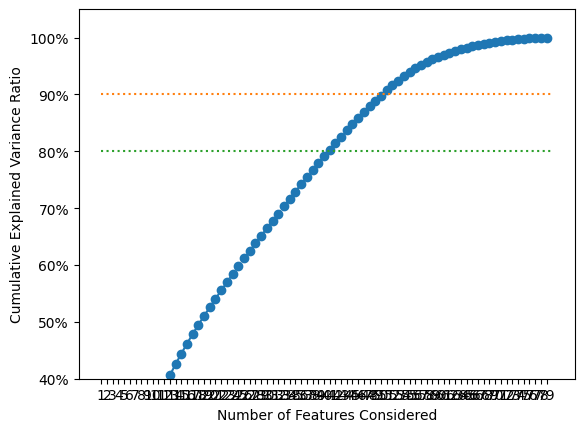

In [131]:
plt.plot(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,79,1),labels=np.arange(1,80,1));
plt.yticks(np.arange(0.4,1.1,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.4,1.1,.1)]);
plt.ylim([0.4,1.05]);
plt.plot([0,79],[.9,.9],':');
plt.plot([0,79],[.8,.8],':');
plt.xlabel("Number of Features Considered");
plt.ylabel("Cumulative Explained Variance Ratio");